###Смотрим на доступные ресурсы

In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [10]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Установка нужных пакетов и импорт библиотек

In [ ]:
!pip install transformers
!pip install opensmile
!pip install pip gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl

In [ ]:
import zipfile
import time
from google.colab import drive
import os
import sys
import librosa
import torch
from torch.utils.data import Dataset
from librosa import display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.nn as nn
import seaborn as sns

import logging
logging.getLogger("transformers").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')


# **Загрузка RAVDESS**

Данные взятыи перекачены отсюда: [RAVDESS](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data), ссылка на скачивание с диска:https://drive.google.com/file/d/1gn79SrzmBDclSP6q75UUs2hZ42cIeqkf/view?usp=sharing или код строчкой ниже:

In [ ]:
!gdown 1gn79SrzmBDclSP6q75UUs2hZ42cIeqkf

Downloading...
From: https://drive.google.com/uc?id=1gn79SrzmBDclSP6q75UUs2hZ42cIeqkf
To: /content/archive.zip
100% 450M/450M [00:06<00:00, 68.3MB/s]


In [ ]:
zip_file1 = '/content/archive.zip'
# Распаковываем архив
z2 = zipfile.ZipFile(zip_file1, 'r')
z2.extractall()

# Просмотр результата разархивации
print(os.listdir())

['.config', 'audio_speech_actors_01-24', 'Actor_20', 'Actor_17', 'Actor_15', 'Actor_02', 'Actor_03', 'Actor_01', 'Actor_13', 'Actor_23', 'Actor_08', 'Actor_14', 'Actor_18', 'Actor_06', 'Actor_22', 'Actor_09', 'Actor_04', 'Actor_07', 'Actor_16', 'Actor_12', 'Actor_24', 'Actor_11', 'Actor_21', 'Actor_05', 'Actor_19', 'archive.zip', 'Actor_10', 'sample_data']


In [ ]:
print(os.listdir('/content/audio_speech_actors_01-24'))

['Actor_20', 'Actor_17', 'Actor_15', 'Actor_02', 'Actor_03', 'Actor_01', 'Actor_13', 'Actor_23', 'Actor_08', 'Actor_14', 'Actor_18', 'Actor_06', 'Actor_22', 'Actor_09', 'Actor_04', 'Actor_07', 'Actor_16', 'Actor_12', 'Actor_24', 'Actor_11', 'Actor_21', 'Actor_05', 'Actor_19', 'Actor_10']


Данные в папке audio_speech_actors_01-24 как будто дублируют тех что в отдельных папках, поэтому вторых отбросим(так понял вторая загруженная версия)

### Создадим класс для работы с входными тренировочными данными

In [ ]:
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised',
}
#audio_length=60000 is taken as an average
class RAVDESSDataset(Dataset):
    def __init__(self, dir, audio_length=60000, actor=None):
        self.audio_length = audio_length
        self.data = []

        if actor is not None:
            self.collect_data(os.path.join(dir, actor))
        else:
            for actor_dir in os.listdir(dir):
                actor_dir_path = os.path.join(dir, actor_dir)
                if os.path.isdir(actor_dir_path):
                    self.collect_data(actor_dir_path)

    def collect_data(self, directory_path):
        for fname in os.listdir(directory_path):
            emotion_id = fname.split('-')[2]
            emotion = emotion_dict[emotion_id]
            wav_filename = os.path.join(directory_path, fname)
            samples, _ = librosa.load(wav_filename, sr=48000)
            samples = librosa.resample(samples, orig_sr=48000, target_sr=16000) #changing sample_rate
            if len(samples) > self.audio_length: # making all samples with the same size
                samples = samples[:self.audio_length]
            elif len(samples) < self.audio_length:
                padding = self.audio_length - len(samples)
                samples = np.concatenate((samples, np.zeros(padding)))
            actor_id = fname.split('-')[6].rstrip('.wav')
            self.data.append((samples, emotion, actor_id))
            #self.data.append((samples, emotion))
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

## Проанализируем данные

Для примера рассмотрим первого актера

In [ ]:
dataset1 = RAVDESSDataset('/content/audio_speech_actors_01-24', actor='Actor_01')

In [ ]:
len(dataset1)

60

In [ ]:
!find /content/audio_speech_actors_01-24/Actor_01 -type f | wc -l

60


отлично, класс перебрал все файлы в первой папке

In [ ]:
for i in range(0, 60):
   for j in range(0, 60):
        assert  len(dataset1[i]) == len(dataset1[j])
        assert dataset1[i][0].shape == dataset1[j][0].shape
print("All arrays are in the same shape!")

All arrays are in the same shape!


In [ ]:
# size of the tuple which is the number of elements in the tuple
tuple_len = len(dataset1[0])
print("Size of the tuple:", tuple_len)

# size of the array
tensor_size = dataset1[0][0].shape
print(f"Size of the array in the tuple: {tensor_size}")

Size of the tuple: 3
Size of the array in the tuple: (60000,)


In [ ]:
# Convert data to a structure where each tensor has been converted to a list
converted_data = [(data.tolist(), str_data1, str_data2) for data, str_data1, str_data2 in dataset1]

# Convert to DataFrame
df = pd.DataFrame(converted_data, columns=['Data', 'Emotion', 'Actor_id'])

df.head(30)

,Data,Emotion,Actor_id
0,"[-0.000740436022169888, -0.0008544254233129323...",disgust,01
1,"[-1.2789769243681803e-13, -3.552713678800501e-...",fearful,01
2,"[3.342393029015511e-11, -4.240519047016278e-11...",surprised,01
3,"[0.0, -2.2737367544323206e-13, -2.273736754432...",disgust,01
4,"[-2.842170943040401e-14, -4.405364961712621e-1...",calm,01
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sad,01
6,"[6.101043226180991e-09, -5.727628149543307e-09...",happy,01
7,"[1.9895196601282805e-13, 2.984279490192421e-13...",happy,01
8,"[2.415641392872203e-05, 2.0974233848392032e-05...",neutral,01
9,"[1.4078636922931764e-07, -1.9284348695691733e-...",neutral,01


посмотрим на потеницально нулевую строку

In [ ]:
second_row = df.iloc[28].apply(str)# for pandas neeed iloc to take value from index and convert to string to apply unique func
unique_values = pd.unique(second_row)
print(unique_values )

['[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

отбой, все норм. Посчитаем частоту встречающихся эмоций

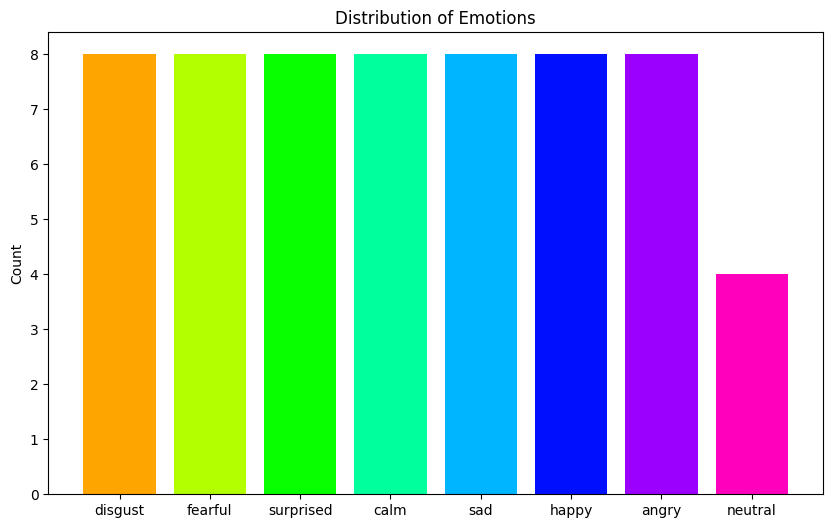

disgust      8
fearful      8
surprised    8
calm         8
sad          8
happy        8
angry        8
neutral      4
Name: Emotion, dtype: int64


In [ ]:
emotion_counts = df['Emotion'].value_counts()

colors = sns.color_palette('hsv', len(emotion_counts.index))

plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.index, emotion_counts.values, color=colors)

plt.ylabel('Count')
plt.title('Distribution of Emotions')

plt.show()
print(emotion_counts)

для всех актеров

In [ ]:
dataset = RAVDESSDataset('/content/audio_speech_actors_01-24')

In [ ]:
from collections import Counter, defaultdict

emotions = [item[1] for item in dataset.data]  # Extracting emotions
emotion_counts = Counter(emotions)

print(emotion_counts)

actor_emotion_counts = defaultdict(Counter)

for sample, emotion, actor in dataset.data:
    actor_emotion_counts[actor][emotion] += 1

for actor, emo_counter in actor_emotion_counts.items():
    print("Actor ID:", actor)
    print("Emotion Counts:", dict(emo_counter))
    print()

Counter({'happy': 192, 'disgust': 192, 'surprised': 192, 'fearful': 192, 'angry': 192, 'calm': 192, 'sad': 192, 'neutral': 96})
Actor ID: 20
Emotion Counts: {'happy': 8, 'disgust': 8, 'surprised': 8, 'fearful': 8, 'angry': 8, 'neutral': 4, 'calm': 8, 'sad': 8}

Actor ID: 17
Emotion Counts: {'sad': 8, 'disgust': 8, 'calm': 8, 'surprised': 8, 'fearful': 8, 'happy': 8, 'angry': 8, 'neutral': 4}

Actor ID: 15
Emotion Counts: {'calm': 8, 'fearful': 8, 'surprised': 8, 'happy': 8, 'angry': 8, 'sad': 8, 'disgust': 8, 'neutral': 4}

Actor ID: 02
Emotion Counts: {'sad': 8, 'calm': 8, 'fearful': 8, 'happy': 8, 'neutral': 4, 'surprised': 8, 'angry': 8, 'disgust': 8}

Actor ID: 03
Emotion Counts: {'neutral': 4, 'disgust': 8, 'calm': 8, 'fearful': 8, 'sad': 8, 'angry': 8, 'happy': 8, 'surprised': 8}

Actor ID: 01
Emotion Counts: {'disgust': 8, 'fearful': 8, 'surprised': 8, 'calm': 8, 'sad': 8, 'happy': 8, 'neutral': 4, 'angry': 8}

Actor ID: 13
Emotion Counts: {'happy': 8, 'fearful': 8, 'angry': 8, 

Видим одинаковое распределение каждой эмоции среди Актеров, встречаемость эмоции 'neutral' вдвое меньше остальных.

In [ ]:
dataset.data = [(samples, emotion) for samples, emotion, actor_id in dataset.data]

In [ ]:
converted_data = [(data.tolist(), str_data1) for data, str_data1 in dataset]

# Convert to DataFrame
df = pd.DataFrame(converted_data, columns=['Data', 'Emotion'])

df.head(30)

,Data,Emotion
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",happy
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",disgust
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",surprised
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",fearful
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",disgust
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",happy
6,"[-2.2737367544323206e-13, 1.9895196601282805e-...",angry
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",angry
8,"[5.850369234394748e-06, 6.325330468825996e-05,...",fearful
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",neutral


# Тут инициализируем нашу модель wav2vec2

Попробуем фреймворк из работы: https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-english.

In [ ]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor, Wav2Vec2Model
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english")
processor = Wav2Vec2Processor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english")# вытаскивает векторное предсатвление признаков каждой аудиоззаписи, далее мы применим ее ко всей выборке
model = Wav2Vec2ForSequenceClassification.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english", num_labels=8)# вывод вектор logits длиной 8


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english and are newly initialized: ['projector.bias', 'classifier.bias', 'classifier.weight', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


"# Checking if the tokenizer has a pad token and if not, setting it\nif tokenizer.pad_token is None:\n    tokenizer.pad_token = '<pad>'\n\n# Checking if the tokenizer has a start of sentence token and if not, setting it\nif tokenizer.cls_token is None:\n    tokenizer.cls_token = '<s>'  # start of sentence marker which is typically used in language models\n\n# Checking if the tokenizer has an end of sentence token and if not, setting it\nif tokenizer.sep_token is None:\n    tokenizer.sep_token = '</s>'  # end of sentence marker"

In [ ]:
index_dict = {v: int(k)-1 for k, v in emotion_dict.items()}# наша модель будет считать индекс 0  за первый класс и тд до 8
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')# используем gpu
def prepare_data(data):
    samples, emotions = data
    samples = samples.numpy()
    inputs = processor(samples.tolist(), sampling_rate=16000, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    targets = torch.tensor([index_dict[emotion] for emotion in emotions]).to(device)

    return {"input_values": inputs['input_values'], "attention_mask": inputs['attention_mask'], "labels": targets}

In [ ]:
#len(index_dict)

##Проверка работы функции

In [ ]:
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised',
}
##{(1-8) -> (0,7)}
samples2 = torch.randn(8, 10)
emotions2 = ['calm', 'surprised', 'neutral', 'happy', 'angry', 'disgust', 'sad', 'fearful']
data = samples2, emotions2
batch2 = prepare_data(data)

In [ ]:
print(batch2)

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.


{'input_values': tensor([[-1.6069, -0.6034,  1.0832, -0.1886,  0.3631, -0.5740,  2.0900,  0.5034,
         -0.8441, -0.2228],
        [ 1.4611, -0.5756,  1.3090,  0.0273, -0.0027, -0.5356, -0.2038, -1.6296,
          1.2633, -1.1135],
        [-0.6522, -0.5164,  1.9930, -0.5259, -1.7882, -0.2550, -0.1734,  0.9819,
          0.8947,  0.0416],
        [-0.6936,  1.1666,  2.1246, -0.6894,  0.3883,  0.3944, -0.7447, -0.4489,
         -1.4506, -0.0467],
        [ 0.8195, -1.1178,  0.5720, -1.7675,  0.3969, -0.6457, -0.2481,  0.1121,
          1.9915, -0.1128],
        [ 2.2011, -0.8368, -0.6759, -0.8078,  0.7581, -0.2990,  0.6512, -1.1649,
         -0.5782,  0.7523],
        [ 1.2291,  0.0643, -1.8294, -1.1144,  0.6968,  0.7573,  0.1528,  0.3072,
          1.0268, -1.2905],
        [-1.4927, -1.4417, -0.9175,  1.5007,  0.0267,  0.0207,  1.5148,  0.0137,
          0.4271,  0.3482]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

Using mask_token, but it is not set yet.


# Основная модель

Провел несколько серий обучения: на размерах батча ниже 16 обучается модель плохо -- за 20-30 эпох точность не выше 20%. Несколько изменил гиперпараметры,поставил рейт 2*10^{-5}при батче 32 -- сильно нестабильная минимизиция функции потерь, посмотрим будет ли переобучение

# Обучим модель( 100 эпох) на a100

In [ ]:
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, random_split
from transformers import AdamW
import torch.utils.data as data

# Изза нехватики ресурсов сокращал данные, но позже использовал всю выборку
#subset_indices = torch.randperm(1150)[:115]  # Adjust this to select the amount of data you want
#sampler = data.SubsetRandomSampler(subset_indices)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
model.to(device)

# Разделим датасет 20 к 80
data_train, data_val = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

train_loader = DataLoader(data_train, batch_size = 32, shuffle=True)
valid_loader = DataLoader(data_val, batch_size = 32)

'''for i, data in enumerate(train_loader):
    print(f"Batch #{i}:", data)
    if i > 1:
        break'''
# стандратный блок для обучения сеток, в каждой эпохе сохраняю значения функций потерь и точность
EPOCHS_TO_TRAIN = 100
optim = AdamW(model.parameters(), lr=2e-5) # тут возможно, нужен тюнинг для улучшения точности
#criterion = CrossEntropyLoss()
train_accuracies = []
val_accuracies = []
val_losses = []
train_losses = []
for epoch in range(EPOCHS_TO_TRAIN):
    model.train()
    total_loss = 0
    all_predictions = []
    all_targets = []
    for batch in train_loader:
        optim.zero_grad()
        input_dict = prepare_data(batch)
        #input_dict = {k: v.to(device) for k, v in input_dict.items()}
        #targets = targets.to(device)
        outputs = model(**input_dict)  # аргументы словаря посылаем в нашу модель
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optim.step()

        predictions = torch.argmax(outputs.logits, dim=-1)  # выбирает индексы максимальных значений вдоль последней оси тензора
        all_predictions.append(predictions.cpu().detach().numpy())
        all_targets.append(input_dict["labels"].cpu().numpy())
        #print(input_dict["labels"], predictions)
    print(f'Epoch: {epoch+1}')
    print(f'Training Loss: {total_loss/len(train_loader)}')
    train_losses.append(total_loss/len(train_loader))
    all_predictions_train = np.concatenate(all_predictions, axis=0)
    all_targets_train = np.concatenate(all_targets, axis=0)


    train_accuracy = accuracy_score(y_true=all_targets_train, y_pred=all_predictions_train)
    train_accuracies.append(train_accuracy)
    print(f'Training Accuracy: {train_accuracy}')
    # теперь брем веса модели и сравниваем с таргетами на валидационной выборке
    model.eval()
    total_val_loss = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batch in valid_loader:
            input_dict = prepare_data(batch)
            outputs = model(**input_dict)
            loss = outputs.loss
            total_val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(input_dict["labels"].cpu().numpy())

    print(f'Validation Loss: {total_val_loss/len(valid_loader)}')
    val_losses.append(total_val_loss/len(valid_loader))

    all_predictions_val = np.concatenate(all_predictions, axis=0)
    all_targets_val = np.concatenate(all_targets, axis=0)

    #Тут точность на валидационной выборке
    val_accuracy = accuracy_score(y_true=all_targets_val, y_pred=all_predictions_val)
    val_accuracies.append(val_accuracy)
    print(f'Validation Accuracy: {val_accuracy}')

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 1
Training Loss: 2.068888670868344
Training Accuracy: 0.1310763888888889
Validation Loss: 2.0626178317599826
Validation Accuracy: 0.12152777777777778


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 2
Training Loss: 2.045182148615519
Training Accuracy: 0.23958333333333334
Validation Loss: 2.0290969610214233
Validation Accuracy: 0.2986111111111111


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 3
Training Loss: 1.9933345350954268
Training Accuracy: 0.3611111111111111
Validation Loss: 1.934945782025655
Validation Accuracy: 0.3333333333333333
Epoch: 4
Training Loss: 1.8622506890032027
Training Accuracy: 0.4375
Validation Loss: 1.7600623766581218
Validation Accuracy: 0.4027777777777778


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 5
Training Loss: 1.7198396258884006
Training Accuracy: 0.4513888888888889
Validation Loss: 1.6088764270146687
Validation Accuracy: 0.4479166666666667
Epoch: 6
Training Loss: 1.5734562145339117
Training Accuracy: 0.5407986111111112


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Validation Loss: 1.4736375543806288
Validation Accuracy: 0.5694444444444444
Epoch: 7
Training Loss: 1.4218921528922186
Training Accuracy: 0.5833333333333334
Validation Loss: 1.3731968535317316
Validation Accuracy: 0.5798611111111112


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 8
Training Loss: 1.2975272470050387
Training Accuracy: 0.6223958333333334
Validation Loss: 1.254191239674886
Validation Accuracy: 0.5868055555555556
Epoch: 9
Training Loss: 1.1765477226840124
Training Accuracy: 0.6605902777777778
Validation Loss: 1.1342897680070665
Validation Accuracy: 0.6631944444444444


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 10
Training Loss: 1.086326938536432
Training Accuracy: 0.6840277777777778
Validation Loss: 1.0740980505943298
Validation Accuracy: 0.6840277777777778


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 11
Training Loss: 0.9796464211410947
Training Accuracy: 0.7309027777777778
Validation Loss: 0.9819976621203952
Validation Accuracy: 0.6875
Epoch: 12
Training Loss: 0.8547819505135218
Training Accuracy: 0.8003472222222222
Validation Loss: 0.9787995417912801
Validation Accuracy: 0.6944444444444444


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 13
Training Loss: 0.7368469304508634
Training Accuracy: 0.8315972222222222
Validation Loss: 0.8326496680577596
Validation Accuracy: 0.7430555555555556


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 14
Training Loss: 0.6792876149217287
Training Accuracy: 0.8637152777777778
Validation Loss: 0.7870172990692986
Validation Accuracy: 0.7777777777777778
Epoch: 15
Training Loss: 0.5954006314277649
Training Accuracy: 0.8802083333333334
Validation Loss: 0.7474428349071078
Validation Accuracy: 0.7743055555555556


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 16
Training Loss: 0.5708108138706949
Training Accuracy: 0.8845486111111112
Validation Loss: 0.7478897505336337
Validation Accuracy: 0.7708333333333334


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 17
Training Loss: 0.5016972877913051
Training Accuracy: 0.9071180555555556
Validation Loss: 0.6158146791987948
Validation Accuracy: 0.8194444444444444
Epoch: 18
Training Loss: 0.43038252492745716
Training Accuracy: 0.9114583333333334
Validation Loss: 0.6936017241742876
Validation Accuracy: 0.7951388888888888


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 19
Training Loss: 0.36991076005829704
Training Accuracy: 0.9366319444444444
Validation Loss: 0.5338465372721354
Validation Accuracy: 0.8541666666666666
Epoch: 20
Training Loss: 0.33046626216835445
Training Accuracy: 0.9392361111111112


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Validation Loss: 0.555563728014628
Validation Accuracy: 0.8159722222222222
Epoch: 21
Training Loss: 0.2925967557562722
Training Accuracy: 0.9522569444444444
Validation Loss: 0.5159758643971549
Validation Accuracy: 0.8506944444444444


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 22
Training Loss: 0.24211368958155313
Training Accuracy: 0.9670138888888888
Validation Loss: 0.5146263821257485
Validation Accuracy: 0.8472222222222222
Epoch: 23
Training Loss: 0.21004604755176437
Training Accuracy: 0.9678819444444444
Validation Loss: 0.43207619918717277
Validation Accuracy: 0.8854166666666666


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 24
Training Loss: 0.15414581344359451
Training Accuracy: 0.9782986111111112
Validation Loss: 0.43441493478086257
Validation Accuracy: 0.8784722222222222


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 25
Training Loss: 0.1574866127015816
Training Accuracy: 0.9661458333333334
Validation Loss: 0.3896743489636315
Validation Accuracy: 0.8854166666666666
Epoch: 26
Training Loss: 0.13643359206616879
Training Accuracy: 0.9704861111111112
Validation Loss: 0.45203805963198346
Validation Accuracy: 0.8715277777777778


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 27
Training Loss: 0.18733166375507912
Training Accuracy: 0.9670138888888888
Validation Loss: 0.4984492030408647
Validation Accuracy: 0.8611111111111112


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 28
Training Loss: 0.10749214566830131
Training Accuracy: 0.9791666666666666
Validation Loss: 0.4505670989553134
Validation Accuracy: 0.8888888888888888
Epoch: 29
Training Loss: 0.14840180297485656
Training Accuracy: 0.9618055555555556
Validation Loss: 0.4756811542643441
Validation Accuracy: 0.8819444444444444


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 30
Training Loss: 0.0711597008113232
Training Accuracy: 0.9861111111111112
Validation Loss: 0.4283638348182042
Validation Accuracy: 0.8993055555555556


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 31
Training Loss: 0.06079540287868844
Training Accuracy: 0.9878472222222222
Validation Loss: 0.47462406009435654
Validation Accuracy: 0.8819444444444444
Epoch: 32
Training Loss: 0.05020413232139415
Training Accuracy: 0.9895833333333334
Validation Loss: 0.5881331496768527
Validation Accuracy: 0.875


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 33
Training Loss: 0.08053859646639062
Training Accuracy: 0.9817708333333334
Validation Loss: 0.5126650681098303
Validation Accuracy: 0.8784722222222222
Epoch: 34
Training Loss: 0.04650534394507607
Training Accuracy: 0.9913194444444444


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Validation Loss: 0.5045684104164442
Validation Accuracy: 0.8888888888888888
Epoch: 35
Training Loss: 0.0780357357321514
Training Accuracy: 0.9782986111111112
Validation Loss: 0.674695599410269
Validation Accuracy: 0.8645833333333334


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 36
Training Loss: 0.05421605082746181
Training Accuracy: 0.9895833333333334
Validation Loss: 0.5730072682102522
Validation Accuracy: 0.8854166666666666
Epoch: 37
Training Loss: 0.035577408529611096
Training Accuracy: 0.9904513888888888
Validation Loss: 0.5800824960072836
Validation Accuracy: 0.8784722222222222


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 38
Training Loss: 0.05211021282917096
Training Accuracy: 0.984375
Validation Loss: 0.6501884592903985
Validation Accuracy: 0.8715277777777778


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 39
Training Loss: 0.020954061325432524
Training Accuracy: 0.9973958333333334
Validation Loss: 0.6974075022670958
Validation Accuracy: 0.8645833333333334
Epoch: 40
Training Loss: 0.03940175806120452
Training Accuracy: 0.9921875
Validation Loss: 0.7169312437375387
Validation Accuracy: 0.8784722222222222


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 41
Training Loss: 0.02607414868867232
Training Accuracy: 0.9930555555555556
Validation Loss: 0.6773830072747337
Validation Accuracy: 0.8715277777777778


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 42
Training Loss: 0.04439721790711499
Training Accuracy: 0.9895833333333334
Validation Loss: 0.6664500774608718
Validation Accuracy: 0.8888888888888888
Epoch: 43
Training Loss: 0.03342750781060507
Training Accuracy: 0.9921875
Validation Loss: 0.5759595332460271
Validation Accuracy: 0.8993055555555556


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 44
Training Loss: 0.019459754474357598
Training Accuracy: 0.9956597222222222
Validation Loss: 0.6700375494029787
Validation Accuracy: 0.8784722222222222


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 45
Training Loss: 0.04577689119873361
Training Accuracy: 0.9921875
Validation Loss: 0.5675398326582379
Validation Accuracy: 0.9097222222222222
Epoch: 46
Training Loss: 0.07220796009318696
Training Accuracy: 0.9835069444444444
Validation Loss: 0.6357983350753784
Validation Accuracy: 0.8958333333333334


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 47
Training Loss: 0.028259115448842447
Training Accuracy: 0.9965277777777778
Validation Loss: 0.65028206176228
Validation Accuracy: 0.9027777777777778
Epoch: 48
Training Loss: 0.07918156549567357
Training Accuracy: 0.9809027777777778
Validation Loss: 0.6409062014685737
Validation Accuracy: 0.8888888888888888


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 49
Training Loss: 0.04026421056025558
Training Accuracy: 0.9887152777777778
Validation Loss: 0.7316749228371514
Validation Accuracy: 0.8784722222222222


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 50
Training Loss: 0.02149186258773423
Training Accuracy: 0.9947916666666666
Validation Loss: 0.7202213505903879
Validation Accuracy: 0.8645833333333334
Epoch: 51
Training Loss: 0.05022169816462944
Training Accuracy: 0.9869791666666666
Validation Loss: 0.6050347569915984
Validation Accuracy: 0.9027777777777778


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 52
Training Loss: 0.02672953142448225
Training Accuracy: 0.9930555555555556
Validation Loss: 0.6305729730261697
Validation Accuracy: 0.8923611111111112


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 53
Training Loss: 0.041921057576675795
Training Accuracy: 0.9913194444444444
Validation Loss: 0.589316860669189
Validation Accuracy: 0.9027777777777778
Epoch: 54
Training Loss: 0.04011954898790767
Training Accuracy: 0.9913194444444444
Validation Loss: 0.6658581644296646
Validation Accuracy: 0.8923611111111112


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 55
Training Loss: 0.01918017875868827
Training Accuracy: 0.9956597222222222
Validation Loss: 0.5825963168301516
Validation Accuracy: 0.9097222222222222


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 56
Training Loss: 0.012830166682963155
Training Accuracy: 0.9973958333333334
Validation Loss: 0.6735666675700082
Validation Accuracy: 0.8854166666666666
Epoch: 57
Training Loss: 0.035183496504840955
Training Accuracy: 0.9930555555555556
Validation Loss: 0.6189310583803389
Validation Accuracy: 0.8993055555555556


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 58
Training Loss: 0.05321913122315891
Training Accuracy: 0.9835069444444444
Validation Loss: 0.5909090174569024
Validation Accuracy: 0.9131944444444444
Epoch: 59
Training Loss: 0.058103628770267174
Training Accuracy: 0.9869791666666666


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Validation Loss: 0.6629671818680234
Validation Accuracy: 0.8923611111111112
Epoch: 60
Training Loss: 0.009406993802662732
Training Accuracy: 0.9973958333333334
Validation Loss: 0.6216412368747923
Validation Accuracy: 0.9027777777777778


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 61
Training Loss: 0.036059439570332565
Training Accuracy: 0.9913194444444444
Validation Loss: 0.6330809775325987
Validation Accuracy: 0.8993055555555556
Epoch: 62
Training Loss: 0.016679467041588698
Training Accuracy: 0.9947916666666666
Validation Loss: 0.48937870122285354
Validation Accuracy: 0.9201388888888888


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 63
Training Loss: 0.0456650824602952
Training Accuracy: 0.9913194444444444
Validation Loss: 0.6943700408769978
Validation Accuracy: 0.8923611111111112


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 64
Training Loss: 0.017841763526020158
Training Accuracy: 0.9956597222222222
Validation Loss: 0.7117120176553726
Validation Accuracy: 0.8993055555555556
Epoch: 65
Training Loss: 0.02587199953591658
Training Accuracy: 0.9947916666666666
Validation Loss: 0.6202451619837019
Validation Accuracy: 0.8958333333333334


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 66
Training Loss: 0.05484071859326731
Training Accuracy: 0.9904513888888888
Validation Loss: 0.7187166603592535
Validation Accuracy: 0.8958333333333334


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 67
Training Loss: 0.037269584957458496
Training Accuracy: 0.9913194444444444
Validation Loss: 0.7933697435590956
Validation Accuracy: 0.8819444444444444
Epoch: 68
Training Loss: 0.038278583611827344
Training Accuracy: 0.9887152777777778
Validation Loss: 0.8143051779932446
Validation Accuracy: 0.875


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 69
Training Loss: 0.02692065271872303
Training Accuracy: 0.9939236111111112
Validation Loss: 0.6417247371541129
Validation Accuracy: 0.90625


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 70
Training Loss: 0.012076016682031978
Training Accuracy: 0.9973958333333334
Validation Loss: 0.7777213611536555
Validation Accuracy: 0.875
Epoch: 71
Training Loss: 0.05493525828933343
Training Accuracy: 0.9878472222222222
Validation Loss: 0.7054378191630045
Validation Accuracy: 0.8923611111111112


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 72
Training Loss: 0.05714031180509159
Training Accuracy: 0.9861111111111112
Validation Loss: 0.5525454028716518
Validation Accuracy: 0.9131944444444444
Epoch: 73
Training Loss: 0.01763455520752662
Training Accuracy: 0.9956597222222222
Validation Loss: 0.7127109782563316
Validation Accuracy: 0.8854166666666666


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 74
Training Loss: 0.073171688696473
Training Accuracy: 0.9835069444444444
Validation Loss: 0.6887223836448457
Validation Accuracy: 0.9027777777777778


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 75
Training Loss: 0.013429016368010908
Training Accuracy: 0.9973958333333334
Validation Loss: 0.7938968042532603
Validation Accuracy: 0.8819444444444444
Epoch: 76
Training Loss: 0.03824098686972219
Training Accuracy: 0.9895833333333334
Validation Loss: 0.5505331344902515
Validation Accuracy: 0.9201388888888888


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 77
Training Loss: 0.04969801512035903
Training Accuracy: 0.9895833333333334
Validation Loss: 0.5301967699649848
Validation Accuracy: 0.9201388888888888


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 78
Training Loss: 0.0470706386937915
Training Accuracy: 0.9921875
Validation Loss: 0.6644201676050822
Validation Accuracy: 0.9027777777777778
Epoch: 79
Training Loss: 0.03196904530179583
Training Accuracy: 0.9930555555555556
Validation Loss: 0.5709821374879943
Validation Accuracy: 0.90625


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 80
Training Loss: 0.05051870505687677
Training Accuracy: 0.9861111111111112
Validation Loss: 0.6959894034597609
Validation Accuracy: 0.90625


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 81
Training Loss: 0.013654422989930026
Training Accuracy: 0.9982638888888888
Validation Loss: 0.6640569137202369
Validation Accuracy: 0.9027777777777778
Epoch: 82
Training Loss: 0.02604539719727149
Training Accuracy: 0.9947916666666666
Validation Loss: 0.5274503197934892
Validation Accuracy: 0.9270833333333334


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 83
Training Loss: 0.01987608353697902
Training Accuracy: 0.9930555555555556
Validation Loss: 0.5811667621083971
Validation Accuracy: 0.90625


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 84
Training Loss: 0.025503233759081922
Training Accuracy: 0.9921875
Validation Loss: 0.6662205308675766
Validation Accuracy: 0.90625
Epoch: 85
Training Loss: 0.01981230369549141
Training Accuracy: 0.9956597222222222
Validation Loss: 0.6315076814757453
Validation Accuracy: 0.9027777777777778


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 86
Training Loss: 0.016668898076103587
Training Accuracy: 0.9965277777777778
Validation Loss: 0.4934375826140038
Validation Accuracy: 0.9270833333333334
Epoch: 87
Training Loss: 0.005009643904890658
Training Accuracy: 0.9982638888888888


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Validation Loss: 0.6053533202244176
Validation Accuracy: 0.9097222222222222
Epoch: 88
Training Loss: 0.00851210173115962
Training Accuracy: 0.9973958333333334
Validation Loss: 0.5263671707361937
Validation Accuracy: 0.9270833333333334


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 89
Training Loss: 0.04572709150508874
Training Accuracy: 0.9904513888888888
Validation Loss: 0.5427414211961958
Validation Accuracy: 0.9166666666666666
Epoch: 90
Training Loss: 0.03932294370719723
Training Accuracy: 0.9930555555555556
Validation Loss: 0.7232818230986595
Validation Accuracy: 0.8958333333333334


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 91
Training Loss: 0.040183872746032044
Training Accuracy: 0.9904513888888888
Validation Loss: 0.5706978320829674
Validation Accuracy: 0.9166666666666666


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 92
Training Loss: 0.025370243093574472
Training Accuracy: 0.9939236111111112
Validation Loss: 0.6086334470245574
Validation Accuracy: 0.9166666666666666
Epoch: 93
Training Loss: 0.04287377828424926
Training Accuracy: 0.9878472222222222
Validation Loss: 0.6858176059193082
Validation Accuracy: 0.8923611111111112


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 94
Training Loss: 0.07849143542666247
Training Accuracy: 0.9861111111111112
Validation Loss: 0.6578933861520555
Validation Accuracy: 0.9097222222222222


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 95
Training Loss: 0.029693935091523196
Training Accuracy: 0.9939236111111112
Validation Loss: 0.723131926128796
Validation Accuracy: 0.8923611111111112
Epoch: 96
Training Loss: 0.0212009046533947
Training Accuracy: 0.9939236111111112
Validation Loss: 0.7163935734166039
Validation Accuracy: 0.8819444444444444


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Epoch: 97
Training Loss: 0.02972490022350232
Training Accuracy: 0.9947916666666666
Validation Loss: 0.7219196326202817
Validation Accuracy: 0.8923611111111112
Epoch: 98
Training Loss: 0.0055978917500599185
Training Accuracy: 0.9982638888888888


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Validation Loss: 0.6414086189534929
Validation Accuracy: 0.90625
Epoch: 99
Training Loss: 0.053798355265623994
Training Accuracy: 0.9878472222222222
Validation Loss: 0.6168656802425782
Validation Accuracy: 0.9166666666666666


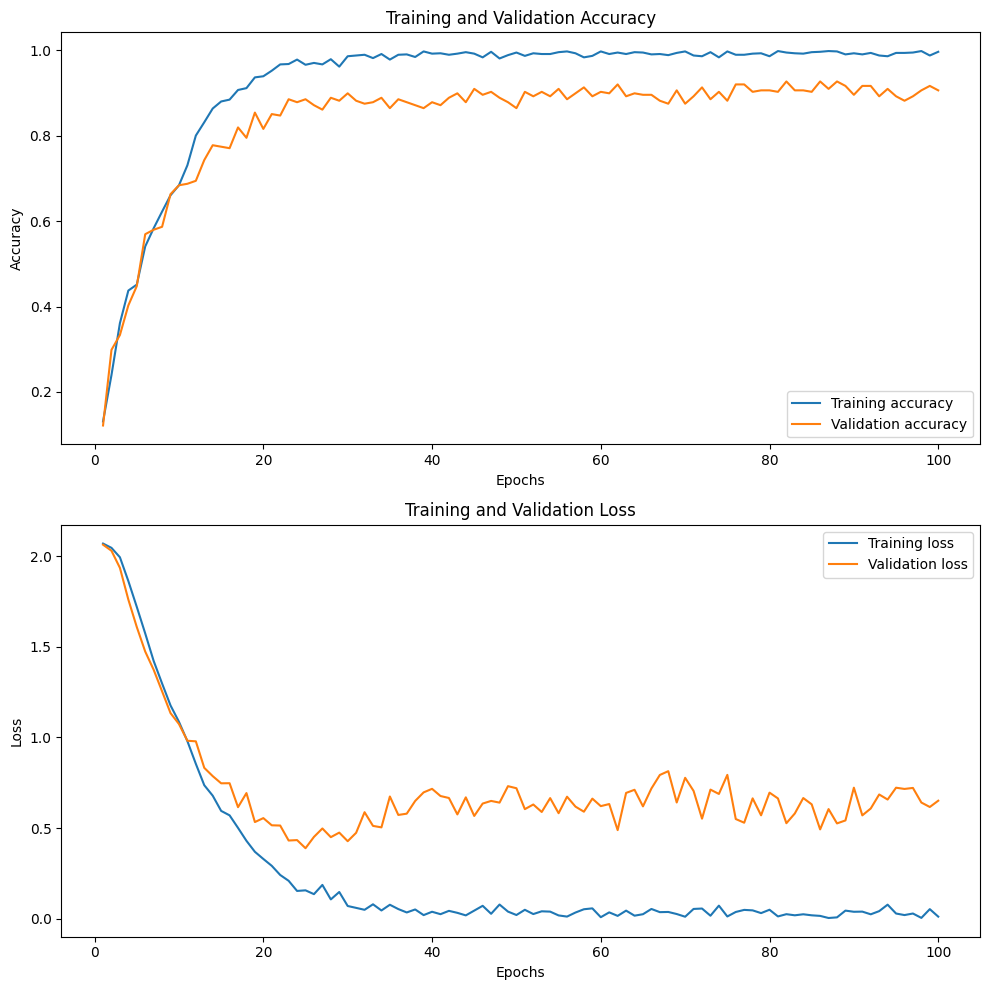

In [ ]:
# Два подграфика, на точность валидационных, тренировочных выборок и минимизация функций потерь
X_values = list(range(1, EPOCHS_TO_TRAIN+1))

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(X_values, train_accuracies, label='Training accuracy')
plt.plot(X_values, val_accuracies, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(X_values, train_losses, label='Training loss')
plt.plot(X_values, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.90625
Classification Report:
               precision    recall  f1-score   support

     neutral       0.77      0.95      0.85        21
        calm       0.92      0.89      0.91        38
       happy       0.85      0.91      0.88        44
         sad       0.85      0.94      0.89        31
       angry       0.81      0.93      0.86        27
     fearful       1.00      0.89      0.94        45
     disgust       1.00      0.86      0.92        43
   surprised       1.00      0.92      0.96        39

    accuracy                           0.91       288
   macro avg       0.90      0.91      0.90       288
weighted avg       0.92      0.91      0.91       288



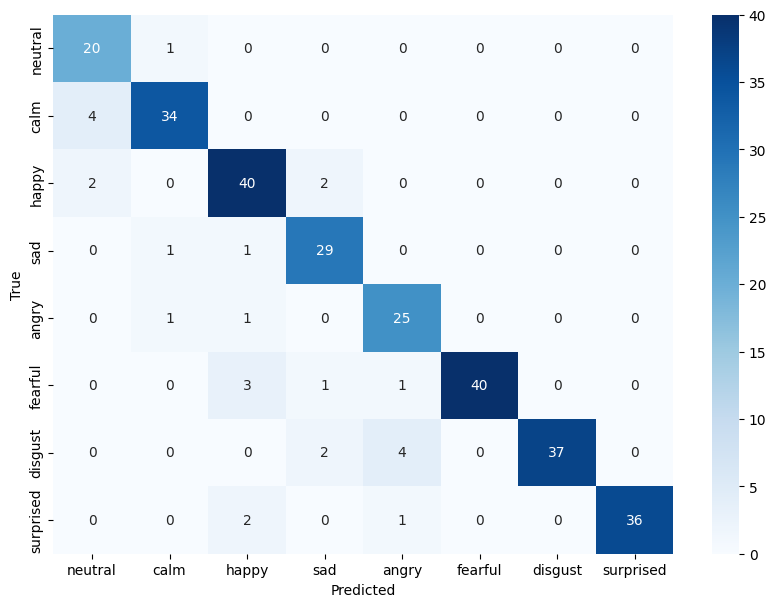

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print(f"Accuracy: {accuracy_score(all_targets_val, all_predictions_val)}")
print(f"Classification Report:\n {classification_report(all_targets_val, all_predictions_val, target_names=emotion_dict.values())}")

cm = confusion_matrix(all_targets_val, all_predictions_val)
df_cm = pd.DataFrame(cm, index=emotion_dict.values(), columns=emotion_dict.values())

plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Видим что модель переобучена. Я бы поменял lr пониже, увеличил размер батча, тк с 40 эпохи большие колебания функции потерь(). Модель слишком сильно начинает подгонятся под тренировочные данные и перестает воспринимать тестовые. С текущими параметрами достаточно 30-40 эпох. Можно попробовать заморозить более старые(у входа) слои предобученной модели wav2vec2 и размораживать их постепенно, начав обучение с выходных слоев.(не пробовал)

Далее выгружаем веса модели, нет необходимости если подгузить готовую с диска

In [ ]:
drive.mount('/content/drive')

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.


Mounted at /content/drive


Using mask_token, but it is not set yet.


In [ ]:
#сохраним модель, веса и параметры Adam(важно не менять их, если брать и дообучать сохраненную модель)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optim.state_dict(),
}, '/content/drive/My Drive/my_model_and_optimizer100.pth')
torch.save(model.state_dict(), '/content/drive/My Drive/my_model100.pth')

# Предсказание эмоций и выгрузка результата

Эта часть независима от предыдущей, начиная с загрузки RAVDESS

Загрузка датасета с диска по ссылке: https://drive.google.com/file/d/1--3dUqmNRJyhj2Ht1gl9ktoRaafbuHhw/view?usp=sharing или строчкой ниже

In [ ]:
!gdown 1--3dUqmNRJyhj2Ht1gl9ktoRaafbuHhw

In [ ]:
zip_file = '/content/test_emotion_dataset.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

print(os.listdir())
#print(os.listdir('original'))


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Инициализируем модель(если же код для обучения модели(Основная модель*) был выполнен, загрузка не требуется)(закоментить строки ниже вплоть до надписи 'Прогон и выгрузка')

In [ ]:
model = Wav2Vec2ForSequenceClassification.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english", num_labels=8)
processor = Wav2Vec2Processor.from_pretrained('jonatasgrosman/wav2vec2-large-xlsr-53-english')
optim = AdamW(model.parameters(), lr=2e-5)

Скачиваем файл с весами модели отсюда: https://drive.google.com/file/d/1ZZPWhGp5fd3VrtBNI4EXo8QF5ogQIUy4/view?usp=sharing  или строчкой ниже

In [ ]:
!gdown 1ZZPWhGp5fd3VrtBNI4EXo8QF5ogQIUy4

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Downloading...
From: https://drive.google.com/uc?id=1ZZPWhGp5fd3VrtBNI4EXo8QF5ogQIUy4
To: /content/my_model_and_optimizer100.pth
100% 3.79G/3.79G [00:21<00:00, 178MB/s]


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


In [ ]:
checkpoint = torch.load('/content/my_model_and_optimizer100.pth')
#optim.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
# update model weights from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Прогон и выгрузка результата:

In [ ]:
from torch.nn.functional import softmax

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Создаем словарь для хранения суммарных вероятностей классов
total_probabilities = {key: 0 for key in emotion_dict.keys()}

# загрузка аудио сигналов с директории original
dir_path = '/content/original/'

with open('output.txt', 'w') as outfile:

    # записываем заголовок таблицы в файл
    header = "|file_id|" + "|".join(list(emotion_dict.keys())) + "|"
    outfile.write(header + '\n')

    # подгружаем каждый файл в этой директории
    for fname in os.listdir(dir_path):
        wav_filename = os.path.join(dir_path, fname)
        # Load and preprocess audio file
        samples, _ = librosa.load(wav_filename, sr=48000)
        samples = librosa.resample(samples, orig_sr=48000, target_sr=16000)
        if len(samples) > 60000:
            samples = samples[:60000]
        elif len(samples) < 60000:
            padding = 60000 - len(samples)
            samples = np.concatenate((samples, np.zeros(padding)))

        # Преобразуем данные к нужному формату
        samples = samples.reshape(1, -1)
        inputs = processor(samples.tolist(), sampling_rate=16000, return_tensors="pt", padding=True)

        inputs = {k: v.to(device) for k, v in inputs.items()}

        output = model(**inputs)

        # Берем softmax чтобы преобразовать линейные выходы в вероятности
        output_softmax = softmax(output.logits, dim=1)

        # Обратно приведем тензор к исходному размеру, отщепим от вычисления градиентов и переводим в numpy
        probabilities = output_softmax.squeeze().detach().cpu().numpy()
        rounded_probabilities = np.round(probabilities, 3)
        # Декодируем метки обратно в эмоции согласно словарю emotion_dict
        probabilities_dict = {list(emotion_dict.keys())[i]: rounded_probabilities[i] for i in range(len(emotion_dict.keys()))}

        print(f"Emotion probabilities for {fname}: {probabilities_dict}")
        #добавляем вероятности текущего файла к общей сумме
        for emotion in total_probabilities.keys():
            total_probabilities[emotion] += 1 if probabilities_dict[emotion] > 0.5 else 0

        # формируем строку результатов для текущего файла и записываем ее в файл
        result_line = f"|{fname}|" + "|".join(str(probabilities_dict[emotion]) for emotion in ['01', '02', '03', '04', '05', '06', '07', '08']) + "|"
        outfile.write(result_line + '\n')
    # Преобразуем словарь с суммарными вероятностями в списки
    emotions = list(total_probabilities.keys())
    probabilities = list(total_probabilities.values())

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Emotion probabilities for 1_29_0.wav: {'01': 0.999, '02': 0.0, '03': 0.0, '04': 0.0, '05': 0.0, '06': 0.0, '07': 0.0, '08': 0.0}
Emotion probabilities for 8_49_4.wav: {'01': 0.0, '02': 0.0, '03': 0.996, '04': 0.0, '05': 0.0, '06': 0.0, '07': 0.0, '08': 0.003}
Emotion probabilities for 10_26_2.wav: {'01': 0.001, '02': 0.0, '03': 0.349, '04': 0.0, '05': 0.645, '06': 0.0, '07': 0.004, '08': 0.0}
Emotion probabilities for 5_22_3.wav: {'01': 0.0, '02': 0.0, '03': 0.0, '04': 1.0, '05': 0.0, '06': 0.0, '07': 0.0, '08': 0.0}
Emotion probabilities for 4_42_3.wav: {'01': 0.0, '02': 0.0, '03': 0.0, '04': 1.0, '05': 0.0, '06': 0.0, '07': 0.0, '08': 0.0}
Emotion probabilities for 4_41_2.wav: {'01': 0.003, '02': 0.0, '03': 0.996, '04': 0.0, '05': 0.0, '06': 0.0, '07': 0.0, '08': 0.0}
Emotion probabilities for 2_38_0.wav: {'01': 0.999, '02': 0.0, '03': 0.0, '04': 0.0, '05': 0.0, '06': 0.0, '07': 0.0, '08': 0.0}
Emotion probabilities for 4_48_0.wav: {'01': 0.73, '02': 0.001, '03': 0.251, '04': 0.014, 

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.


Emotion probabilities for 7_42_4.wav: {'01': 0.0, '02': 0.0, '03': 0.0, '04': 0.0, '05': 0.0, '06': 0.0, '07': 0.0, '08': 1.0}
Emotion probabilities for 5_30_4.wav: {'01': 0.0, '02': 0.0, '03': 0.999, '04': 0.0, '05': 0.0, '06': 0.0, '07': 0.0, '08': 0.0}
Emotion probabilities for 6_25_3.wav: {'01': 0.0, '02': 1.0, '03': 0.0, '04': 0.0, '05': 0.0, '06': 0.0, '07': 0.0, '08': 0.0}
Emotion probabilities for 8_39_0.wav: {'01': 0.999, '02': 0.0, '03': 0.001, '04': 0.0, '05': 0.0, '06': 0.0, '07': 0.0, '08': 0.0}
Emotion probabilities for 6_45_4.wav: {'01': 0.0, '02': 0.0, '03': 0.996, '04': 0.0, '05': 0.0, '06': 0.0, '07': 0.0, '08': 0.004}
Emotion probabilities for 10_37_1.wav: {'01': 0.353, '02': 0.0, '03': 0.003, '04': 0.0, '05': 0.643, '06': 0.0, '07': 0.0, '08': 0.0}
Emotion probabilities for 7_40_4.wav: {'01': 0.0, '02': 0.0, '03': 0.011, '04': 0.0, '05': 0.0, '06': 0.0, '07': 0.001, '08': 0.987}
Emotion probabilities for 3_24_4.wav: {'01': 0.0, '02': 0.0, '03': 0.999, '04': 0.0, '05

Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


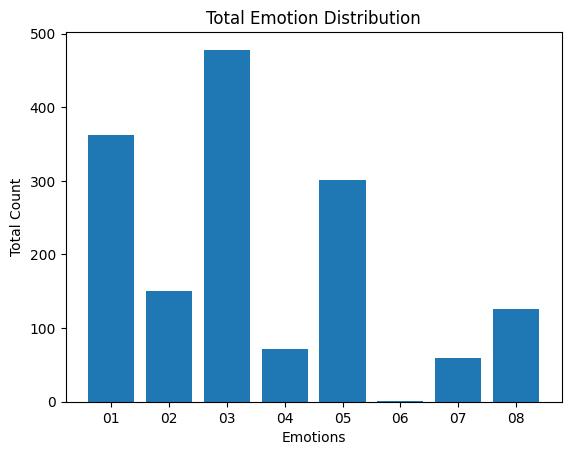

In [ ]:
# Создаем график столбцов
plt.bar(emotions, probabilities)
plt.xlabel('Emotions')
plt.ylabel('Total Count')
plt.title('Total Emotion Distribution')
plt.show()


Интересно сравнить результат распределения по классам c RAVDESS. Напоминаю там количество вхождений neutral было вдвое меньше, остальные поровну. Удивляет fearful, модель его практически не видет. Sad и disgust почти ровно предсказывает, но больше предсказании падает на happy. Напомню, что f1 score обученной модели показал что, точность предсказаний растет для: neutral, angry, sad, calm, surprised, disgust, happy, fearfull(от худшего к лучшему). (во удивительно будет, если в тестовом датасете все классы равнораспределены...)

напоминаю вокаб:

In [ ]:
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised',
}

# Бейзлайн модель

In [ ]:
import librosa
import opensmile
from google.colab import drive

import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import IPython.display as ipd
import zipfile

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


**Коэффициенты Mel-частоты (MFCC)(важные характеристики сигналов для задач классфикации) извлекаются как спектральный признак, а openSMILE используется для извлечения паралингвистического признака, который, содержит метод mfcc. Посмотрим на функциональные особенности сигналов**

In [ ]:
dir = '/content/audio_speech_actors_01-24'
list_of_paths = []
for actor_dir in os.listdir(dir):
            actor_dir_path = os.path.join(dir, actor_dir)
            if not os.path.isdir(actor_dir_path):
                continue
            for fname in os.listdir(actor_dir_path):
                paths = os.path.join(actor_dir_path, fname)
                list_of_paths.append(paths)
print(list_of_paths)

['/content/audio_speech_actors_01-24/Actor_20/03-01-03-01-01-02-20.wav', '/content/audio_speech_actors_01-24/Actor_20/03-01-07-02-01-01-20.wav', '/content/audio_speech_actors_01-24/Actor_20/03-01-08-02-02-02-20.wav', '/content/audio_speech_actors_01-24/Actor_20/03-01-06-01-02-01-20.wav', '/content/audio_speech_actors_01-24/Actor_20/03-01-07-02-02-02-20.wav', '/content/audio_speech_actors_01-24/Actor_20/03-01-03-02-01-01-20.wav', '/content/audio_speech_actors_01-24/Actor_20/03-01-05-02-02-01-20.wav', '/content/audio_speech_actors_01-24/Actor_20/03-01-05-01-02-02-20.wav', '/content/audio_speech_actors_01-24/Actor_20/03-01-06-02-02-01-20.wav', '/content/audio_speech_actors_01-24/Actor_20/03-01-01-01-02-02-20.wav', '/content/audio_speech_actors_01-24/Actor_20/03-01-06-02-01-01-20.wav', '/content/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-01-20.wav', '/content/audio_speech_actors_01-24/Actor_20/03-01-02-01-02-01-20.wav', '/content/audio_speech_actors_01-24/Actor_20/03-01-05-02-02-02-

In [ ]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
smile.process_files(list_of_paths)

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not s

,,,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
file,start,end,,,,,,,,,,,,,,,,,,,,,
/content/audio_speech_actors_01-24/Actor_20/03-01-03-01-01-02-20.wav,0 days,0 days 00:00:03.703687500,39.415287,0.096873,36.333076,40.389530,42.499832,6.166756,56.979347,32.942841,34.461803,15.553396,...,0.113141,0.014993,0.009969,1.897019,0.824176,0.486667,0.297807,0.527500,0.508103,-41.720043
/content/audio_speech_actors_01-24/Actor_20/03-01-07-02-01-01-20.wav,0 days,0 days 00:00:04.104104167,42.380829,0.157765,37.026009,42.290390,47.134407,10.108398,102.951714,15.871696,82.675797,29.632111,...,0.107822,0.012541,0.017899,2.444988,1.237624,0.288000,0.135558,0.415000,0.406397,-44.796829
/content/audio_speech_actors_01-24/Actor_20/03-01-08-02-02-02-20.wav,0 days,0 days 00:00:03.436770833,39.369076,0.066503,36.966362,39.831116,41.651958,4.685596,82.218056,32.033554,36.041122,17.116158,...,0.105604,0.014360,0.018076,1.754386,1.186944,0.297500,0.159902,0.690000,0.403237,-40.150745
/content/audio_speech_actors_01-24/Actor_20/03-01-06-01-02-01-20.wav,0 days,0 days 00:00:03.937270833,40.918446,0.224496,35.311417,38.200378,39.343513,4.032097,64.918694,29.165522,42.671978,0.000000,...,0.115624,0.011432,0.006711,1.785714,1.291990,0.186000,0.129861,0.471667,0.436784,-51.788849
/content/audio_speech_actors_01-24/Actor_20/03-01-07-02-02-02-20.wav,0 days,0 days 00:00:03.870520833,41.266010,0.141970,37.527370,43.394901,45.414921,7.887550,9.526665,59.143456,90.977661,27.099571,...,0.096787,0.009403,0.022269,2.331606,1.574803,0.253333,0.201963,0.308571,0.320108,-37.789848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/content/audio_speech_actors_01-24/Actor_10/03-01-06-02-01-02-10.wav,0 days,0 days 00:00:03.703708333,41.468128,0.118047,38.906174,42.660889,44.173985,5.267811,86.198196,27.700897,132.753647,206.229065,...,0.034085,0.005794,0.024406,2.439024,1.098901,0.377500,0.465423,0.408000,0.376850,-28.852779
/content/audio_speech_actors_01-24/Actor_10/03-01-05-01-01-01-10.wav,0 days,0 days 00:00:03.903895833,32.854958,0.063247,31.435385,32.536499,34.000671,2.565287,33.691097,18.040298,25.486288,8.797995,...,0.059500,0.002484,0.028533,2.570694,0.781250,0.543333,0.332098,0.535000,0.483555,-36.379269
/content/audio_speech_actors_01-24/Actor_10/03-01-04-02-01-01-10.wav,0 days,0 days 00:00:03.503499999,36.245850,0.124299,34.083462,37.031406,39.752331,5.668869,161.776733,0.000000,21.179613,0.000000,...,0.029852,0.003735,0.023933,2.865330,1.162791,0.342500,0.340615,0.492500,0.337741,-33.627254


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


In [ ]:
features = smile.process_files(list_of_paths)

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not s

In [ ]:
features.to_csv('features.csv')

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


In [ ]:
features = pd.read_csv('features.csv')

In [ ]:
df = pd.DataFrame(features)

In [ ]:
df.iloc[0, 0]

'/content/audio_speech_actors_01-24/Actor_20/03-01-03-01-01-02-20.wav'

In [ ]:
df = df.drop(df.columns[1], axis=1)
#преобразуем вторую колону в секунды
df['end'] = pd.to_timedelta(df['end'])
df['end'] = df['end'].dt.total_seconds()
df = df.rename(columns={'end': 'time'})
df.head(10)

,file,time,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,/content/audio_speech_actors_01-24/Actor_20/03...,3.703688,39.415287,0.096873,36.333076,40.389530,42.499832,6.166756,56.979347,32.942840,...,0.113141,0.014993,0.009969,1.897019,0.824176,0.486667,0.297807,0.527500,0.508103,-41.720043
1,/content/audio_speech_actors_01-24/Actor_20/03...,4.104104,42.380830,0.157765,37.026010,42.290390,47.134407,10.108398,102.951710,15.871696,...,0.107822,0.012541,0.017899,2.444988,1.237624,0.288000,0.135558,0.415000,0.406397,-44.796830
2,/content/audio_speech_actors_01-24/Actor_20/03...,3.436771,39.369076,0.066503,36.966362,39.831116,41.651960,4.685596,82.218056,32.033554,...,0.105604,0.014360,0.018076,1.754386,1.186944,0.297500,0.159902,0.690000,0.403237,-40.150745
3,/content/audio_speech_actors_01-24/Actor_20/03...,3.937271,40.918446,0.224496,35.311417,38.200380,39.343513,4.032097,64.918690,29.165522,...,0.115624,0.011432,0.006711,1.785714,1.291990,0.186000,0.129861,0.471667,0.436784,-51.788850
4,/content/audio_speech_actors_01-24/Actor_20/03...,3.870521,41.266010,0.141970,37.527370,43.394900,45.414920,7.887550,9.526665,59.143456,...,0.096787,0.009403,0.022269,2.331606,1.574803,0.253333,0.201963,0.308571,0.320108,-37.789850
5,/content/audio_speech_actors_01-24/Actor_20/03...,3.670333,43.289055,0.102561,39.750248,43.323880,47.520134,7.769886,106.003550,62.218636,...,0.119404,0.018173,0.011440,1.639344,0.831025,0.513333,0.310948,0.663333,0.455802,-32.735043
6,/content/audio_speech_actors_01-24/Actor_20/03...,4.404417,46.130444,0.130940,42.014590,47.378033,50.922504,8.907913,152.696850,74.425360,...,0.091082,0.012288,0.109010,2.050114,1.152074,0.404000,0.164024,0.440000,0.416317,-18.452406
7,/content/audio_speech_actors_01-24/Actor_20/03...,3.803792,40.767630,0.155740,35.742233,40.302402,43.622063,7.879829,257.148220,131.224430,...,0.088513,0.007426,0.022297,2.110818,2.139037,0.205000,0.180485,0.205556,0.283867,-35.730990
8,/content/audio_speech_actors_01-24/Actor_20/03...,3.870542,49.086514,0.170232,38.635662,49.950990,57.662910,19.027248,158.018070,82.775750,...,0.064815,0.007799,0.060322,1.813472,0.787402,0.543333,0.511490,0.700000,0.424343,-18.343693
9,/content/audio_speech_actors_01-24/Actor_20/03...,3.536875,36.696194,0.142967,34.489487,38.351665,40.914757,6.425270,14.760263,4.354505,...,0.108971,0.013765,0.009326,1.988636,1.440922,0.228000,0.142464,0.370000,0.436157,-48.979275


Названия файлов нам даром не нужны, а вот классы на которые они указывают будут использоваться при классификации. Переобработаем их, как в начале ноутбука

In [ ]:
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised',
}
df['file'] = df['file'].str.split('/').str[-1]  # разделим по /
df['file'] = df['file'].str.split('-').str[2]   # берем третее число
df['file'] = df['file'].astype(int)  # конвертируем в целые
df = df.rename(columns={'file': 'emotion_id'})
df.head(10)

,emotion_id,time,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,3,3.703688,39.415287,0.096873,36.333076,40.389530,42.499832,6.166756,56.979347,32.942840,...,0.113141,0.014993,0.009969,1.897019,0.824176,0.486667,0.297807,0.527500,0.508103,-41.720043
1,7,4.104104,42.380830,0.157765,37.026010,42.290390,47.134407,10.108398,102.951710,15.871696,...,0.107822,0.012541,0.017899,2.444988,1.237624,0.288000,0.135558,0.415000,0.406397,-44.796830
2,8,3.436771,39.369076,0.066503,36.966362,39.831116,41.651960,4.685596,82.218056,32.033554,...,0.105604,0.014360,0.018076,1.754386,1.186944,0.297500,0.159902,0.690000,0.403237,-40.150745
3,6,3.937271,40.918446,0.224496,35.311417,38.200380,39.343513,4.032097,64.918690,29.165522,...,0.115624,0.011432,0.006711,1.785714,1.291990,0.186000,0.129861,0.471667,0.436784,-51.788850
4,7,3.870521,41.266010,0.141970,37.527370,43.394900,45.414920,7.887550,9.526665,59.143456,...,0.096787,0.009403,0.022269,2.331606,1.574803,0.253333,0.201963,0.308571,0.320108,-37.789850
5,3,3.670333,43.289055,0.102561,39.750248,43.323880,47.520134,7.769886,106.003550,62.218636,...,0.119404,0.018173,0.011440,1.639344,0.831025,0.513333,0.310948,0.663333,0.455802,-32.735043
6,5,4.404417,46.130444,0.130940,42.014590,47.378033,50.922504,8.907913,152.696850,74.425360,...,0.091082,0.012288,0.109010,2.050114,1.152074,0.404000,0.164024,0.440000,0.416317,-18.452406
7,5,3.803792,40.767630,0.155740,35.742233,40.302402,43.622063,7.879829,257.148220,131.224430,...,0.088513,0.007426,0.022297,2.110818,2.139037,0.205000,0.180485,0.205556,0.283867,-35.730990
8,6,3.870542,49.086514,0.170232,38.635662,49.950990,57.662910,19.027248,158.018070,82.775750,...,0.064815,0.007799,0.060322,1.813472,0.787402,0.543333,0.511490,0.700000,0.424343,-18.343693
9,1,3.536875,36.696194,0.142967,34.489487,38.351665,40.914757,6.425270,14.760263,4.354505,...,0.108971,0.013765,0.009326,1.988636,1.440922,0.228000,0.142464,0.370000,0.436157,-48.979275


In [ ]:
print(df.columns)

Index(['emotion_id', 'time', 'F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope',
       'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope',
       'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean',
       'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean',
       'mfcc1_sma

Построим корреляционную матрицу и посмотрим можно ли выкинуть часть столбцов, скоррелированных или неинформативных. Если абсолютное значение коэффициента корреляции между двумя переменными выше чем threshhold = 0.9, мы отбрасываем одну из переменных(столбец)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Будем считать корреляционную матрицу
corr = df.corr()

correlated_features = set()

# вычисляем значения и заполняем
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            column_name = corr.columns[i]
            correlated_features.add(column_name)

# отбрасывая сильно скореллированные признаки
df = df.drop(columns = correlated_features)

df.head(10)

,emotion_id,time,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,loudness_sma3_amean,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,3,3.703688,39.415287,0.096873,6.166756,56.979347,32.942840,34.461803,15.553396,0.221274,...,0.113141,0.014993,0.009969,1.897019,0.824176,0.486667,0.297807,0.527500,0.508103,-41.720043
1,7,4.104104,42.380830,0.157765,10.108398,102.951710,15.871696,82.675800,29.632110,0.172124,...,0.107822,0.012541,0.017899,2.444988,1.237624,0.288000,0.135558,0.415000,0.406397,-44.796830
2,8,3.436771,39.369076,0.066503,4.685596,82.218056,32.033554,36.041122,17.116158,0.259001,...,0.105604,0.014360,0.018076,1.754386,1.186944,0.297500,0.159902,0.690000,0.403237,-40.150745
3,6,3.937271,40.918446,0.224496,4.032097,64.918690,29.165522,42.671978,0.000000,0.074507,...,0.115624,0.011432,0.006711,1.785714,1.291990,0.186000,0.129861,0.471667,0.436784,-51.788850
4,7,3.870521,41.266010,0.141970,7.887550,9.526665,59.143456,90.977660,27.099571,0.327437,...,0.096787,0.009403,0.022269,2.331606,1.574803,0.253333,0.201963,0.308571,0.320108,-37.789850
5,3,3.670333,43.289055,0.102561,7.769886,106.003550,62.218636,95.839660,49.626392,0.459340,...,0.119404,0.018173,0.011440,1.639344,0.831025,0.513333,0.310948,0.663333,0.455802,-32.735043
6,5,4.404417,46.130444,0.130940,8.907913,152.696850,74.425360,103.189255,78.944050,1.207585,...,0.091082,0.012288,0.109010,2.050114,1.152074,0.404000,0.164024,0.440000,0.416317,-18.452406
7,5,3.803792,40.767630,0.155740,7.879829,257.148220,131.224430,62.399822,43.583164,0.366968,...,0.088513,0.007426,0.022297,2.110818,2.139037,0.205000,0.180485,0.205556,0.283867,-35.730990
8,6,3.870542,49.086514,0.170232,19.027248,158.018070,82.775750,114.762880,107.046260,1.318396,...,0.064815,0.007799,0.060322,1.813472,0.787402,0.543333,0.511490,0.700000,0.424343,-18.343693
9,1,3.536875,36.696194,0.142967,6.425270,14.760263,4.354505,24.931261,0.000000,0.122628,...,0.108971,0.013765,0.009326,1.988636,1.440922,0.228000,0.142464,0.370000,0.436157,-48.979275


Хорошо, почистили, но по прежнему многовато признаков. Вобще, если бы данные набирались из монотонных или инструментальных дорожек, достаточно было бы проанализировать (8-10) признаков(спектрограммы, магнитуда, mel диаграммы и тд). Не зная почти ничего об извлеченных признаках из аудиофайлов, попробуем нарисовать кластеры (наивно)уменьшая размерность признаков до 3, максимизируя дисперсию в данных

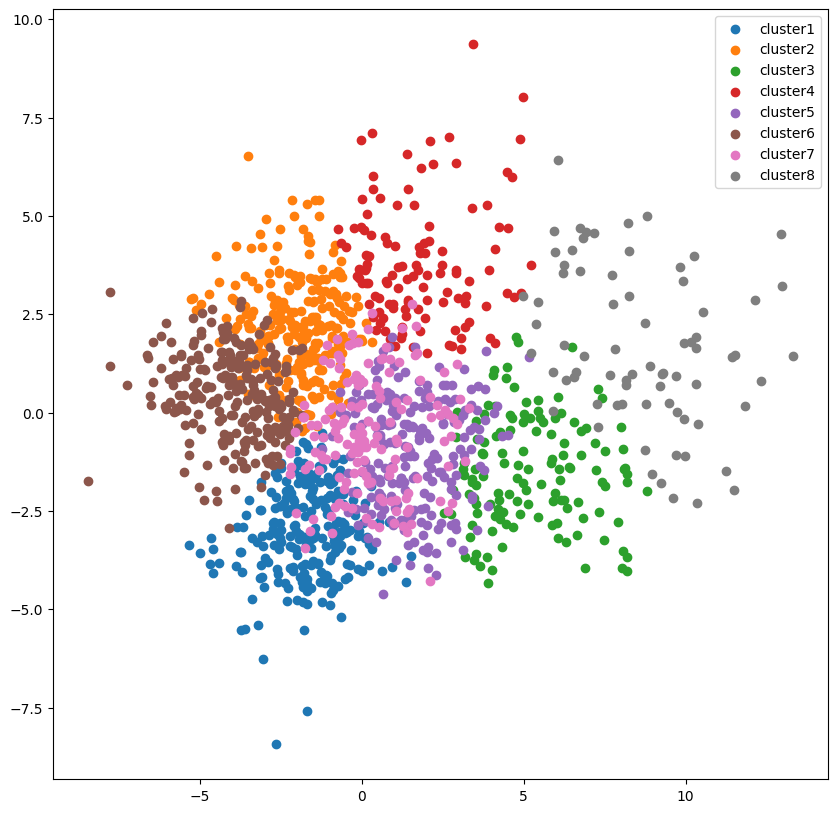

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df1 = scaler.fit_transform(df)
# Выполните уменьшение размерности с помощью PCA
pca = PCA(n_components=3)  # (n_components refers to the top n features sort by variance)
features_pca = pca.fit_transform(df1)

kmeans = KMeans(n_clusters=8, random_state=42).fit(features_pca) # методом ближайшего соседа посмотрим на результат

# Plotting the clusters
plt.figure(figsize=(10, 10))

for i in range(8):
    plt.scatter(features_pca[kmeans.labels_ == i, 0], features_pca[kmeans.labels_ == i, 1], label=f'cluster{i+1}')

plt.legend()
plt.show()

## Решаем задачу классификации, используя решающие деревья

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X = df.drop('emotion_id', axis = 1)
y = df['emotion_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(n_estimators=500)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


In [ ]:
print(classification_report(y_test, y_pred))

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.


              precision    recall  f1-score   support

           1       0.47      0.33      0.39        21
           2       0.67      0.91      0.77        35
           3       0.51      0.38      0.44        47
           4       0.60      0.67      0.63        36
           5       0.61      0.53      0.57        32
           6       0.57      0.53      0.55        38
           7       0.61      0.63      0.62        43
           8       0.56      0.67      0.61        36

    accuracy                           0.59       288
   macro avg       0.57      0.58      0.57       288
weighted avg       0.58      0.59      0.58       288



Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Результат не так уж плох, предлагаю использовать больши фитчей, такие как: MFCCs, Pitch, Energy, Chroma Features, Spectral Contrast, Harmonics, Formants

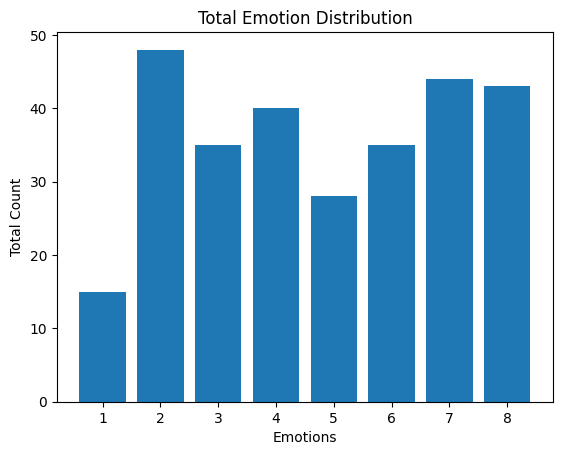

In [ ]:
# Считаем количество каждого класса
class_distribution = Counter(y_pred)

# Преобразуем Counter в список меток классов и список счётчиков этих классов
classes = list(class_distribution.keys())
counts = list(class_distribution.values())

# Создаем график столбцов
plt.bar(classes, counts)
plt.xlabel('Emotions')
plt.ylabel('Total Count')
plt.title('Total Emotion Distribution')
plt.show()

Сравним с основной моделью -- совершенно различное распределение.

# C новыми силами к новым признакам для бейзлайн модели

 Существует прекрасная коллекция [Видео](https://https://www.youtube.com/watch?v=R-5uxKTRjzM&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=14), чтобы освежить знания об обработке сигналов. Я склонен выбирать несколько основных функций (7,8), поскольку Feature_extractor из wav2vec объединяется... в вектор размером 8. (будем работать в тех же размерностях, но это не значит, разумеется, что информативность признаков у меня и у processor в word2vec2 одинковые)

Помним, что датасет устроен так, что часть фразы отображающие одинаковые эмоции повторяются, их важно Не удалить поскольку они несут в себе некотрые возмущения исходного 'идеального' сигнала, и нам важно при тренировки нейронки чтобы учитовать отклонения от нормы, с другой стороны можно повозиться и дополнительно порабаотать с аугментацией, добавив шумы и неслаженную речь и тд, но это уже другая задача.

## Обработка Сигнала

На сей раз воспользуемся librosa, для извлечения основных признаков для сигналов(energy, chroma, mfcc, spectral contrast, pitches and magnitudes). Работа похожая было проделана в одной из серии [Audio Emotion](https://www.kaggle.com/code/ejlok1/audio-emotion-part-2-feature-extract/notebook) в Kaggle. Например, после применения mfcc имеем двумерную картину, но можно редуцировать одну ось усреднив по времени коэффициенты, и утверждается так что картина 'глубины' не потеряет информативность признаков. Продеомонстрируем на следующем примере.

In [ ]:
ipd.Audio('/content/Actor_01/03-01-02-02-02-02-01.wav')

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


22050


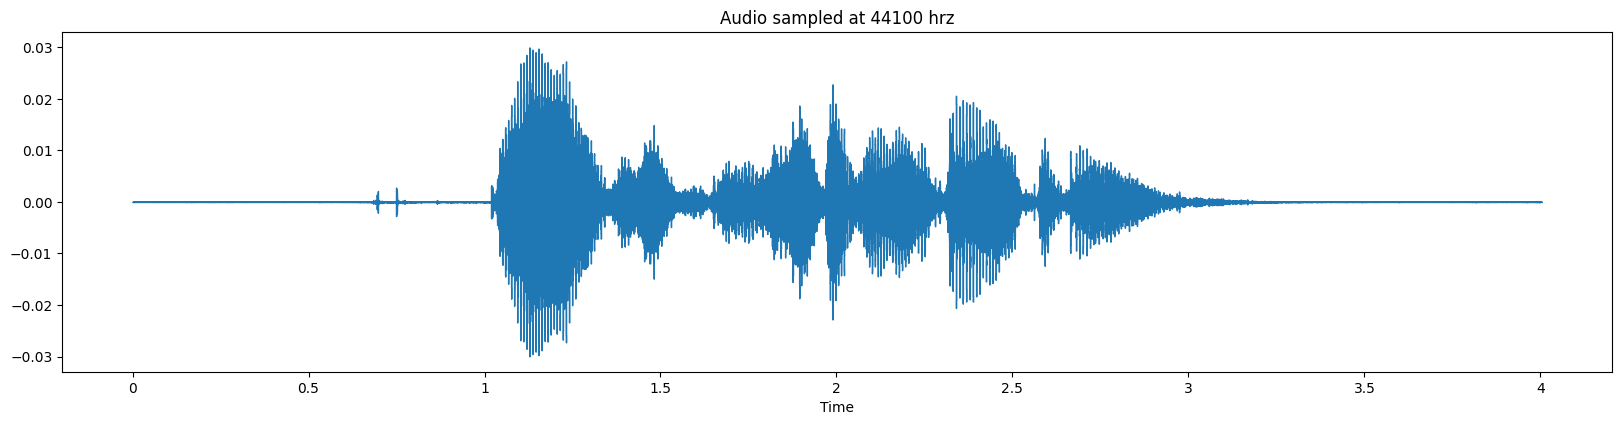

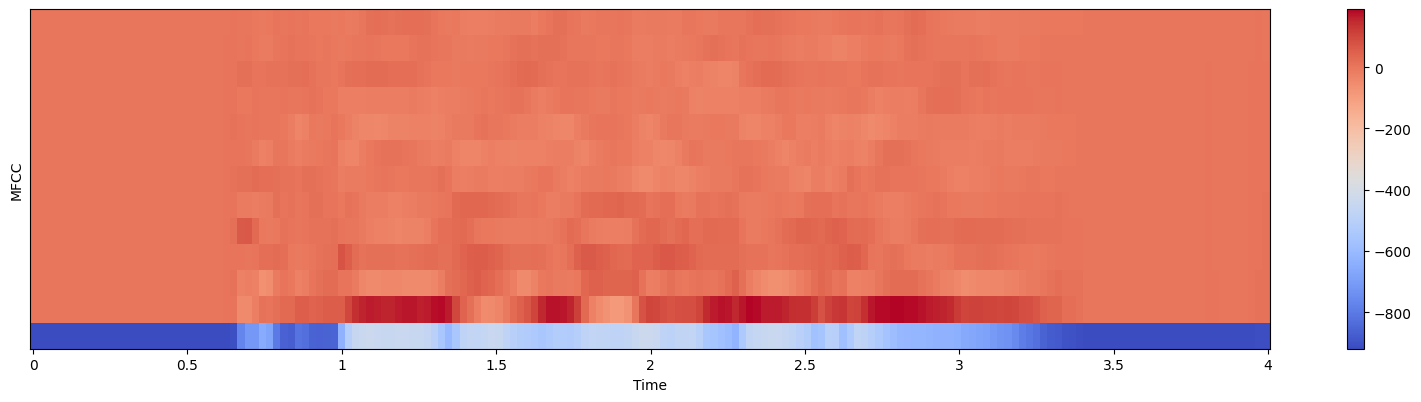

In [ ]:
signal1, sample_rate1 = librosa.load('/content/Actor_01/03-01-02-02-02-02-01.wav')
print(sample_rate1)
mfcc1 = librosa.feature.mfcc(y=signal1, sr=sample_rate1, n_mfcc=13)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(signal1, sr=sample_rate1)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc1, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


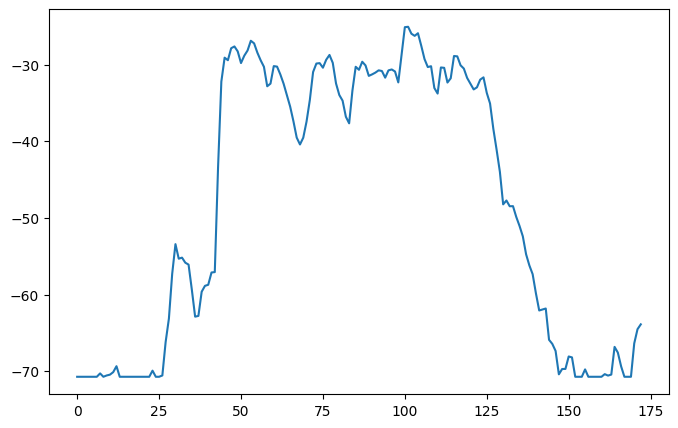

In [ ]:
Actor_neutral = np.mean(librosa.feature.mfcc(y=signal1, sr=sample_rate1, n_mfcc=13), axis=0)# важно, использую 13 mfcc которая часто используется в качестве характеристики в аудио
# беря среднее по времени каждого фрейма в матрице  и выпремляем в вектор признаков каждый из коэффициентов
# audio wave
plt.figure(figsize=(8, 5))
plt.plot(Actor_neutral)

Возьмем еще несколько эмоций для сравнения с той же фразой и Aктором1 и выберем ту же фразу для другого Актера20, анализируем графики:

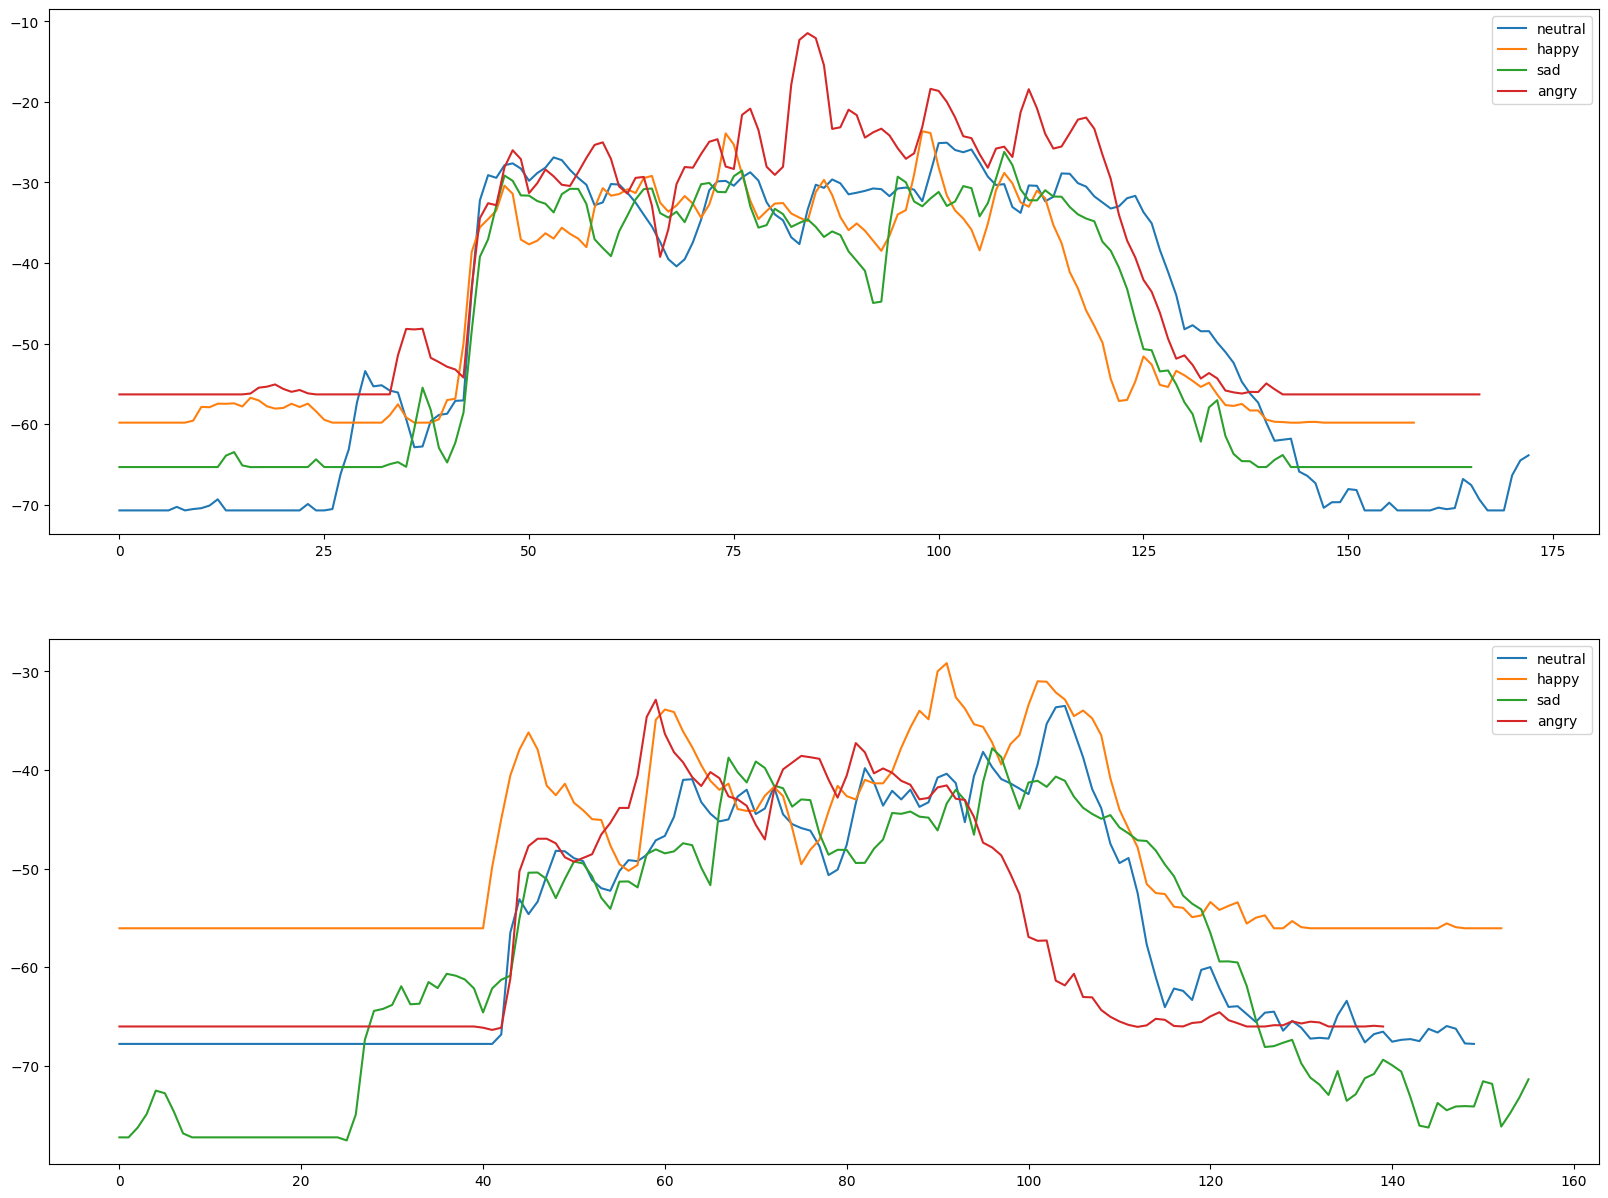

In [ ]:
Actor_neutral = np.mean(librosa.feature.mfcc(y=signal1, sr=sample_rate1, n_mfcc=13), axis=0)

signal2, sample_rate2 = librosa.load('/content/Actor_01/03-01-03-02-01-01-01.wav')
Actor_happy = np.mean(librosa.feature.mfcc(y=signal2, sr=sample_rate2, n_mfcc=13), axis=0)

signal3, sample_rate3 = librosa.load('/content/Actor_01/03-01-04-01-01-01-01.wav')
Actor_sad = np.mean(librosa.feature.mfcc(y=signal3, sr=sample_rate3, n_mfcc=13), axis=0)

signal4, sample_rate4 = librosa.load('/content/Actor_01/03-01-05-01-01-01-01.wav')
Actor_angry= np.mean(librosa.feature.mfcc(y=signal4, sr=sample_rate4, n_mfcc=13), axis=0)
##########################################################################################################################
sig1, sr1 = librosa.load('/content/Actor_20/03-01-01-01-01-01-20.wav')
Actor20_neutral = np.mean(librosa.feature.mfcc(y=sig1, sr=sr1, n_mfcc=13), axis=0)

sig2, sr2 = librosa.load('/content/Actor_20/03-01-03-01-01-01-20.wav')
Actor20_happy = np.mean(librosa.feature.mfcc(y=sig2, sr=sr2, n_mfcc=13), axis=0)

sig3, sr3 = librosa.load('/content/Actor_20/03-01-04-01-01-01-20.wav')
Actor20_sad = np.mean(librosa.feature.mfcc(y=sig3, sr=sr3, n_mfcc=13), axis=0)

sig4, sr4 = librosa.load('/content/Actor_20/03-01-05-01-01-01-20.wav')
Actor20_angry = np.mean(librosa.feature.mfcc(y=sig4, sr=sr4, n_mfcc=13), axis=0)

plt.figure(figsize=(20, 15))

plt.subplot(2, 1, 1)
plt.plot(Actor_neutral, label='neutral')
plt.plot(Actor_happy, label='happy')
plt.plot(Actor_sad, label='sad')
plt.plot(Actor_angry, label='angry')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(Actor20_neutral, label='neutral')
plt.plot(Actor20_happy, label='happy')
plt.plot(Actor20_sad, label='sad')
plt.plot(Actor20_angry, label='angry')
plt.legend()

plt.show()


Видно что на самой фразе(информативная часть) радость более амплитудная, грусть за исключением некоторых всплесков держится ниже нейтралальности, злость так же амплитудная как и радость. Итог: на графиках можно разделить яркие эмоции от пассивных, для дальнейшей работы нужен детальный анализ спектральных характеристик, имеет смысл обратить внимание на гармоники (chroma) из библиотеки librosa, так как перепады частот в голосе что отображается в изминении тембора можно поискать там. Энергию как квадрат амплитуды важно тоже учесть чтобы выделить амплитудные сигналы от остальных, еще воспользуемся спектральным контрастом чтобы сравнить амплитуды в пиках различных эмоций, и фундаментальную частоту каждых сигналов тоже рассмотрим

## Извлечем описанные признаки

In [ ]:
def extract_features(file_name):

   audio, sample_rate = librosa.load(file_name, sr = 48000)

   energy = np.sum(audio ** 2)

   # Chroma features
   chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)

   # Spectral contrast
   spectral_contrast = librosa.feature.spectral_contrast(y = audio, sr=sample_rate)

   # MFCC (Mel-frequency cepstral coefficients)
   mfcc_mean_in_time = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13), axis=0)

   # Pitch - the piptrack method
   pitches, magnitudes = librosa.piptrack(y = audio, sr=sample_rate)

   return file_name, energy, chroma, spectral_contrast, mfcc_mean_in_time, pitches


features = []

for file in list_of_paths:
   f, e, c, s, m, p = extract_features(file)
   features.append([f, e, np.mean(c), np.max(s), np.min(m), np.max(m), np.mean(p)]) #mean/max is not informative....(

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


создадим фрейм для работы с данными

In [ ]:
df2 = pd.DataFrame(features, columns=['file', 'energy', 'mean_chroma', 'max_spectral_contrast', 'min_mfcc','max_mfcc', 'pitch'])

df2.head(10)

,file,energy,mean_chroma,max_spectral_contrast,min_mfcc,max_mfcc,pitch
0,/content/audio_speech_actors_01-24/Actor_20/03...,11.918913,0.340980,41.729053,-63.126484,-30.686039,29.990715
1,/content/audio_speech_actors_01-24/Actor_20/03...,6.505115,0.413593,39.491148,-64.258347,-27.292599,31.711246
2,/content/audio_speech_actors_01-24/Actor_20/03...,15.854984,0.394397,36.133465,-60.066467,-25.316172,36.092522
3,/content/audio_speech_actors_01-24/Actor_20/03...,1.246280,0.404013,46.145271,-68.883224,-36.666077,36.151585
4,/content/audio_speech_actors_01-24/Actor_20/03...,30.818911,0.419883,43.529392,-58.977654,-26.253439,34.435722
5,/content/audio_speech_actors_01-24/Actor_20/03...,93.581741,0.358907,39.999008,-53.809433,-31.977690,33.401882
6,/content/audio_speech_actors_01-24/Actor_20/03...,3009.114746,0.388297,44.407280,-39.213188,-10.825397,32.586945
7,/content/audio_speech_actors_01-24/Actor_20/03...,48.613239,0.490349,43.707293,-55.634342,-28.184177,41.225372
8,/content/audio_speech_actors_01-24/Actor_20/03...,2712.892578,0.459653,42.095193,-43.249008,-10.858296,48.773705
9,/content/audio_speech_actors_01-24/Actor_20/03...,2.137124,0.408176,40.059574,-68.520248,-32.301968,31.475035


In [ ]:
df2['file'] = df2['file'].str.split('/').str[-1]
df2['file'] = df2['file'].str.split('-').str[2]
df2['file'] = df2['file'].astype(int)
df2 = df2.rename(columns={'file': 'emotion_id'})
df2.head(10)

,emotion_id,energy,mean_chroma,max_spectral_contrast,min_mfcc,max_mfcc,pitch
0,3,11.918913,0.340980,41.729053,-63.126484,-30.686039,29.990715
1,7,6.505115,0.413593,39.491148,-64.258347,-27.292599,31.711246
2,8,15.854984,0.394397,36.133465,-60.066467,-25.316172,36.092522
3,6,1.246280,0.404013,46.145271,-68.883224,-36.666077,36.151585
4,7,30.818911,0.419883,43.529392,-58.977654,-26.253439,34.435722
5,3,93.581741,0.358907,39.999008,-53.809433,-31.977690,33.401882
6,5,3009.114746,0.388297,44.407280,-39.213188,-10.825397,32.586945
7,5,48.613239,0.490349,43.707293,-55.634342,-28.184177,41.225372
8,6,2712.892578,0.459653,42.095193,-43.249008,-10.858296,48.773705
9,1,2.137124,0.408176,40.059574,-68.520248,-32.301968,31.475035


Обучим Случайный Лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X = df2.drop('emotion_id', axis = 1)
y = df2['emotion_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(n_estimators=200)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
df2.to_csv('features2.csv')

              precision    recall  f1-score   support

           1       0.33      0.14      0.20        21
           2       0.34      0.57      0.43        35
           3       0.32      0.23      0.27        47
           4       0.31      0.31      0.31        36
           5       0.52      0.50      0.51        32
           6       0.26      0.21      0.23        38
           7       0.29      0.28      0.29        43
           8       0.19      0.25      0.21        36

    accuracy                           0.31       288
   macro avg       0.32      0.31      0.31       288
weighted avg       0.32      0.31      0.31       288



Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


результат так себе, всего вдвое выше вероятности выбрать эмоцию наугад, даже не буду смотреть на распределение. Значит, наивным усреднением целого массива данных или беря макс и мин, хороших точности на валидационной выборке не видать. Собственно, как это делалось в статье в Kaggle, неплохо бы взять весь массив спектральных коэффицентов и обучиться на нем, но даже там, результат около 43%(на 20% ниже чем получилось взятием функциональных признаков из библиотеки asmile), но в пределах этого датасета разумеется. По хорошему, нужна теория более глубокая для ручного отбора признаков, либо одна из идей использовать сверточную сеть CNN для отбора этих признаков, а для классфификации, например, использовать тот же Случайный Лес